# Label Propagation

Label propagation is similar to training a classification model and then using that model to make predictions on test data. The key difference is that in general, our analogue to the test data has no labels against which to evaluate our model. In this exercise, we keep the entire set of true labels for illustrative purposes, but the vast marjority of them play no role in training the model. 

This exercise is adapted from scikit-learn's [tutorial](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html) on zero shot learning .

### Load the necessary modules and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading

from sklearn.metrics import confusion_matrix, classification_report

### Exercise: Load and preprocess the data. 
1. Shuffle the indices
2. Use the shuffled indices to extract 1000 random samples from the features data
3. Extract the corresponding 1000 labels and images
4. Copy the labels. Treat the first 50 shuffled samples as labeled data and the rest as unlabeled data. Replace the labels after the first 50 with -1.

We'll use this copy of our labels (with 50 labels known and the other 950 hidden) to train our model, and use the original copy (with all 1000 labels known) to evaluate the model.

In [2]:
# Load the digits dataset
# digits = {data,target,indices}; n = 1797
digits = datasets.load_digits()

def get_data(n_total_samples, n_labeled_points):
    # Set the random state to 2 for reproducibility
    rng = np.random.RandomState(2)

    # Initialize the indices as an ordered array, with each element corresponding to a sample in the dataset
    indices = np.arange(len(digits.data))

    # Shuffle the indices
    rng.shuffle(indices)

    # Use the shuffled indices to extract 1000 feature vectors, labels, and images
    #n_total_samples = 1000
    # Features
    X = digits.data[indices[:n_total_samples]]
    # Labels
    y = digits.target[indices[:n_total_samples]]
    # Images
    images = digits.images[indices[:n_total_samples]]

    # Copy the labels
    y_train = np.copy(y)

    # Replace all of the elements of y_train after the first 50 with -1, rendering them unlabeled
    #n_labeled_points = 50
    # Create an ordered array of indices of the training data
    train_indices = np.arange(len(y_train))
    # Define the training data indices after n_labeled_points as unlabeled
    unlabeled_set = range(n_labeled_points, len(y_train))
    # Conduct the label replacement
    y_train[unlabeled_set] = -1
    return X, y, y_train, unlabeled_set, images

In [3]:
def get_model(X, y_train, gamma = 0.25, max_iter = 20):
    # Initialize the model
    lp_model = LabelSpreading(gamma=0.25, max_iter = 20)
    # Train the model
    lp_model.fit(X, y_train)
    return lp_model

In [4]:
def model_assessment(model, true_labels):
    # Extract the label predictions for the unlabeled data
    predicted_labels = model.transduction_[unlabeled_set]

    # Extract the true labels of the unlabeled data
    #true_labels = y[unlabeled_set]
    # Compute the confusion matrix between the true and predicted labels of the unlabeled data
    cm = confusion_matrix(true_labels, predicted_labels, labels=model.classes_)

    print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
          (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

In [14]:
def examine_uncertain_predictions(model):
    # Calculate uncertainty values for each transduced distribution

    pred_entropies = stats.distributions.entropy(model.label_distributions_.T)

    # Pick the top 10 most uncertain labels, in descending order of uncertainty
    uncertainty_index = np.argsort(pred_entropies)[-10:]

    # Plot
    f = plt.figure(figsize=(7, 5))
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        sub = f.add_subplot(2, 5, index + 1)
        sub.imshow(image, cmap=plt.cm.gray_r)
        plt.xticks([])
        plt.yticks([])
        sub.set_title('predict: %i\ntrue: %i' % (
            model.transduction_[image_index], y[image_index]))

    f.suptitle('Learning with small amount of labeled data')
    plt.show()

Verify that the labels are randomly distributed and all the labels after the first 50 in `y_train` are hidden

In [5]:
n_total_samples = 1000
n_labeled_points = 50
X, y, y_train, unlabeled_set, images = get_data(n_total_samples, n_labeled_points)
print(y_train[0:100])

[ 4  0  9  1  4  7  1  5  1  6  6  7  6  1  5  5  4  6  2  7  4  6  4  1
  5  2  9  5  4  6  5  6  3  4  0  9  9  8  4  6  8  8  5  7  9  6  9  6
  1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


### Do: 
Train the label propagation model with `gamma = 0.25` and `max_iter = 20`


In [6]:
lp_model_50 = get_model(X, y_train, gamma = 0.25, max_iter = 20)

### Do: 
Evaluate the model's performance on the unlabeled data

In [7]:
true_labels = y[unlabeled_set]
model_assessment(lp_model_50, true_labels)

Label Spreading model: 50 labeled & 950 unlabeled points (1000 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.85      0.90      0.88        93
           2       0.99      0.78      0.87        91
           3       0.92      0.90      0.91       108
           4       0.97      1.00      0.98        88
           5       0.97      0.93      0.95       102
           6       0.97      1.00      0.99       100
           7       0.98      0.91      0.94        91
           8       0.86      0.82      0.84        87
           9       0.77      0.97      0.86        92

    accuracy                           0.92       950
   macro avg       0.93      0.92      0.92       950
weighted avg       0.93      0.92      0.92       950

Confusion matrix
[[ 98   0   0   0   0   0   0   0   0   0]
 [  0  84   0   0   1   1   0   0   3   4]
 [  0  12  71   0   0   0   0   1   7   0]
 [  0   0   0  97   0   0

<!-- ### Exercise: Find the 10 most uncertain labels in descending order of uncertainty, i.e. the labels for which the model made the least confident predictions. Plot the associated images. Observe any discrepancies between predicted and true labels. Do you see any patterns? What might account for them? -->

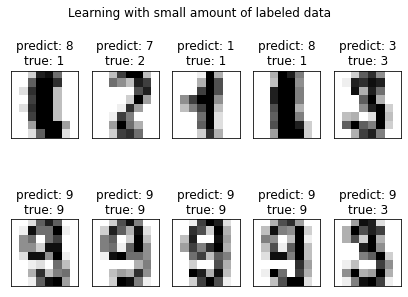

In [15]:
# Examine the 10 most uncertain labels
examine_uncertain_predictions(lp_model_50)

## Observations

Ones (1) and nines (9) are the most uncertain for the 50 labeled model to predict, though it had less actual trouble predicting nines than ones.

### Repeat the experiment with 10, 100, and 250 labeled images. 

How do the differing numbers of labeled samples affect the model's performance? Which number detections yield the most errors?




########## Run analysis for 10 images ##########
Label Spreading model: 10 labeled & 990 unlabeled points (1000 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       0.40      0.93      0.56        96
           2       0.00      0.00      0.00        93
           3       0.00      0.00      0.00       110
           4       0.76      0.97      0.85        94
           5       0.92      0.94      0.93       108
           6       0.95      0.99      0.97       109
           7       0.91      0.99      0.95        94
           8       0.00      0.00      0.00        90
           9       0.34      0.77      0.47        97

    accuracy                           0.66       990
   macro avg       0.53      0.66      0.57       990
weighted avg       0.53      0.66      0.58       990

Confusion matrix
[[ 99   0   0   0   0   0   0]
 [  0  89   1   0   5   0   1]
 [  0   0  91   0   0   3   0]
 [  0   0   

/home/leon/opt/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leon/opt/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leon/opt/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

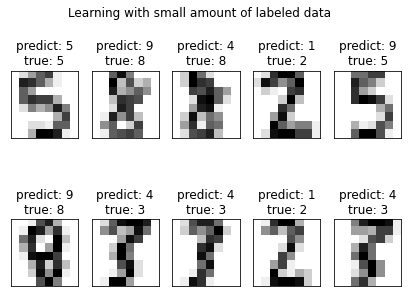



########## Run analysis for 100 images ##########
Label Spreading model: 100 labeled & 900 unlabeled points (1000 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       0.92      0.99      0.96        87
           2       1.00      0.90      0.95        88
           3       0.93      0.96      0.95        99
           4       0.98      1.00      0.99        84
           5       0.97      0.93      0.95        97
           6       1.00      1.00      1.00        97
           7       1.00      0.91      0.95        85
           8       0.96      0.92      0.94        78
           9       0.83      0.96      0.89        90

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900

Confusion matrix
[[95  0  0  0  0  0  0  0  0  0]
 [ 0 86  0  0  0  1  0  0  0  0]
 [ 0  4 79  3  0  0  0  0  2  0]
 [

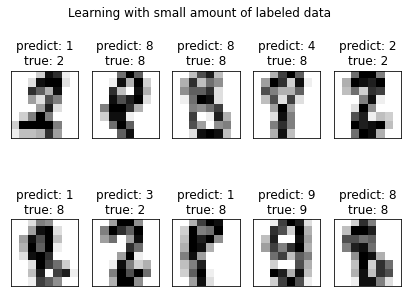



########## Run analysis for 250 images ##########
Label Spreading model: 250 labeled & 750 unlabeled points (1000 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       0.93      0.97      0.95        70
           2       1.00      0.90      0.95        70
           3       0.91      0.99      0.95        80
           4       1.00      1.00      1.00        73
           5       0.99      0.93      0.96        81
           6       1.00      1.00      1.00        86
           7       1.00      0.99      0.99        67
           8       0.94      0.89      0.91        66
           9       0.89      0.96      0.92        76

    accuracy                           0.96       750
   macro avg       0.97      0.96      0.96       750
weighted avg       0.97      0.96      0.96       750

Confusion matrix
[[81  0  0  0  0  0  0  0  0  0]
 [ 0 68  0  0  0  1  0  0  1  0]
 [ 0  4 63  1  0  0  0  0  2  0]
 [

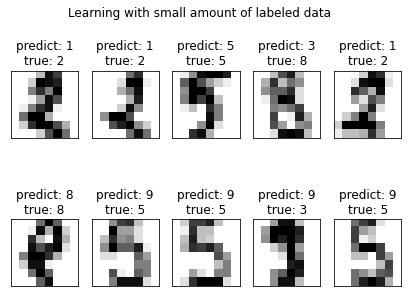

In [18]:
for num_labeled_images in [10, 100, 250]:
    print(f"########## Run analysis for {num_labeled_images} images ##########")
    n_total_samples = 1000
    n_labeled_points = num_labeled_images
    X, y, y_train, unlabeled_set, images = get_data(n_total_samples, n_labeled_points)
    model = get_model(X, y_train, gamma = 0.25, max_iter = 20)
    true_labels = y[unlabeled_set]
    model_assessment(model, true_labels)
    examine_uncertain_predictions(model)
    print(f"\n")

## Observations

The 10 labeled images model produced the most errors having a weighted average f1-score  of 0.58 compared to 0.96 for both the 100 and 250 labeled image models.  We can conclude that 10 images was insufficient to bootstrap the semisupervised learning process.  Additionally, there is a threshold for the number of labeled images above which the semisupervised learning process provide no additional benefits beyond traditional classification. 

## Goal

The goal of this exercise if to identify the instances when misclassification occurs the most. Label spreading applied sample neighborhood to assign labels to unlabelled samples which may lead to misclassifications. For more details on the assessment please see https://benlevinson.com/projects/comparing-knn-svm-mnist